In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

c:\users\anany\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\anany\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\users\anany\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\users\anany\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


#### Reading the URLs for every User

In [2]:
def save_article_text(url):
    # Set headers to mimic a web browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    # Send a GET request to the URL with headers
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the title, subtitle, description, and main text
    title_element = soup.find('title')
    title = title_element.text.strip() if title_element else ""

    subtitle_element = soup.find('meta', attrs={'name': 'description'})
    subtitle = subtitle_element['content'].strip() if subtitle_element and 'content' in subtitle_element.attrs else ""

    description_element = soup.find('meta', attrs={'name': 'og:description'})
    description = description_element['content'].strip() if description_element and 'content' in description_element.attrs else ""

    # Find and exclude unwanted elements by class names or content patterns
    unwanted_elements = soup.find_all(['script', 'style', 'a', 'div', 'span'], class_=['follow-us', 'newsletter', 'advertisement'])
    patterns_to_exclude = ['next article', 'read next', 'correlated']
    for element in unwanted_elements:
        if any(pattern in str(element).lower() for pattern in patterns_to_exclude):
            element.extract()

    # Find and exclude footer container and "All rights reserved" text
    footer_elements = soup.find_all(['footer', 'div'], class_=['footer', 'bottom-footer'])
    for element in footer_elements:
        element.extract()
    all_rights_reserved_elements = soup.find_all(text=re.compile(r'\bAll rights reserved\b', re.IGNORECASE))
    for element in all_rights_reserved_elements:
        element.extract()

    # Find the main text element(s) based on the HTML structure of the page
    main_text_elements = soup.find_all('p')
    main_text = "\n\n".join([element.text.strip() for element in main_text_elements if element.text.strip()])

    # Set the subtitle to the description if it is empty
    if not subtitle:
        subtitle = description.strip()

    # Concatenate the extracted strings
    article_text = f"{title}\n\n{subtitle}\n\n{main_text}"

    return article_text

In [3]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

In [189]:
excel_file = pd.read_excel('Day 3 - 9th Nov/User10.xlsx')

dfs = []
for url in excel_file.iloc[:, 0]:  # Assuming the URLs are in the first column
    article_text = save_article_text(url)
    sentences = sent_tokenize(article_text)
    df = pd.DataFrame(sentences, columns=['sent'])
    dfs.append(df)

In [190]:
dfs[1].tail()

,sent
47,Remove some to bookmark this image.
48,"Your session has expired, please login again."
49,You are now subscribed to our newsletters.
50,In case you can’t find any email from our side...
51,This is a subscriber only feature Subscribe No...


#### Training the Model

In [2]:
data = pd.read_csv('output.csv')

In [3]:
'''
Encoding Labels - transform labels into numbers
'''
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data['labels'] = LE.fit_transform(data['label'])
data.head()

,embedding,label,labels
0,Former Apostolic Nuncio to the United States A...,0,0
1,In this tragic moment for the Church in variou...,1,1
2,— bishops have a very grave responsibility,1,1
3,I am thinking in particular of the United Stat...,0,0
4,"The Bishops of the United States are called , ...",0,0


In [4]:
from sklearn.model_selection import train_test_split

X, y = data['embedding'], data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# generating the embeddings for the training dataset in one go
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import torch

final_model = RandomForestClassifier()

embedding_list = []
label_list = []

batch_size = 32
total_samples = len(X_train)

start_idx = 0
end_idx = batch_size

while start_idx < total_samples:
    # select batches
    train_batch = X_train.values.tolist()[start_idx:end_idx]

    # tokenize the batches
    tokenized_batch = tokenizer(train_batch, padding=True, truncation=True, return_tensors="pt")
    tokenized_batch = {k: torch.tensor(v).to(device) for k, v in tokenized_batch.items()}

    # generate embeddings
    with torch.no_grad():
        hidden_batch = model(**tokenized_batch)
    cls_batch = hidden_batch.last_hidden_state[:, 0, :]

    # labels for the selected batch
    labels_batch = y_train.values[start_idx:end_idx]
    
    # extending the embeddings and labels list
    embedding_list.extend(cls_batch.cpu().numpy().tolist())
    label_list.extend(labels_batch)

    start_idx = end_idx
    end_idx = min(end_idx + batch_size, total_samples)



C:\Users\anany\AppData\Local\Temp\ipykernel_14376\3674843027.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_batch = {k: torch.tensor(v).to(device) for k, v in tokenized_batch.items()}


In [7]:
# file with embeddings
data = pd.DataFrame({'embeddings': embedding_list, 'labels': label_list})
data.to_csv('Data/embeddings_and_labels.csv', index=False)

In [8]:
# generating embeddings for the testing dataset
embedding_list = []
label_list = []

batch_size = 32
total_samples = len(X_test)

start_idx = 0
end_idx = batch_size

while start_idx < total_samples:
    test_batch = X_test.values.tolist()[start_idx:end_idx]

    tokenized_batch = tokenizer(test_batch, padding=True, truncation=True, return_tensors="pt")
    tokenized_batch = {k: torch.tensor(v).to(device) for k, v in tokenized_batch.items()}

    with torch.no_grad():
        hidden_batch = model(**tokenized_batch)
    cls_batch = hidden_batch.last_hidden_state[:, 0, :]

    labels_batch = y_test.values[start_idx:end_idx]

    embedding_list.extend(cls_batch.cpu().numpy().tolist())
    label_list.extend(labels_batch)

    start_idx = end_idx
    end_idx = min(end_idx + batch_size, total_samples)

data_test = pd.DataFrame({'embeddings': embedding_list, 'labels': label_list})
data_test.to_csv('Data/test_embeddings_and_labels.csv', index=False)

C:\Users\anany\AppData\Local\Temp\ipykernel_14376\1299656439.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_batch = {k: torch.tensor(v).to(device) for k, v in tokenized_batch.items()}


In [9]:
data_test = pd.read_csv('Data/test_embeddings_and_labels.csv')
data_train = pd.read_csv('Data/embeddings_and_labels.csv')

In [10]:
import ast

data_train['embeddings'] = data_train['embeddings'].apply(lambda x: ast.literal_eval(x))

X = data_train['embeddings'].to_list()
y = data_train['labels'].to_list()

# Now, X should contain numerical arrays or lists that can be used to fit the model
final_model.fit(X, y)

RandomForestClassifier()

In [11]:
data_test['embeddings'] = data_test['embeddings'].apply(lambda x: ast.literal_eval(x))

X_test = data_test['embeddings'].to_list()
y_test = data_test['labels'].to_list()

In [12]:
y_pred = final_model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Micro F1 Score:", micro_f1)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7614471452798192
F1 Score: 0.7199243090481391
Micro F1 Score: 0.7614471452798192
Macro F1 Score: 0.6023236735563605


In [15]:
import pickle

#with open('model.pkl', 'wb') as file:
#    pickle.dump(final_model, file)

with open('model.pkl', 'rb') as file:
    final_model = pickle.load(file)
file.close()


#### Generating Embeddings for the dfs

In [191]:
for dataset in dfs:
    tokenized_data = tokenizer(dataset["sent"].values.tolist(), padding = True, truncation = True, return_tensors="pt")

    #move on device (GPU)
    tokenized_data = {k:torch.tensor(v).to(device) for k,v in tokenized_data.items()}
    
    with torch.no_grad():
        hidden_data = model(**tokenized_data) #dim : [batch_size(nr_sentences), tokens, emb_dim]

    #get only the [CLS] hidden states
    cls_data = hidden_data.last_hidden_state[:,0,:]
    x_data = cls_data.to("cpu")
    #dataset['embedding'] = cls_data.cpu().numpy().tolist()
    y_data = final_model.predict(x_data)
    dataset['labels'] = y_data

C:\Users\anany\AppData\Local\Temp\ipykernel_27328\3104918035.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_data = {k:torch.tensor(v).to(device) for k,v in tokenized_data.items()}
C:\Users\anany\AppData\Local\Temp\ipykernel_27328\3104918035.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_data = {k:torch.tensor(v).to(device) for k,v in tokenized_data.items()}
C:\Users\anany\AppData\Local\Temp\ipykernel_27328\3104918035.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_data = {k:torch.tensor(v).to(de

In [192]:
dfs[4].tail()

,sent,labels
18,Remove some to bookmark this image.,0
19,"Your session has expired, please login again.",0
20,You are now subscribed to our newsletters.,0
21,In case you can’t find any email from our side...,0
22,This is a subscriber only feature Subscribe No...,0


In [193]:
user_info = []
for df in dfs:
    num_positive_sentences = df['labels'].sum()
    total_sentences = len(df)

    user_info.append({'Num_Positive_Sentences': num_positive_sentences, 'Total_Sentences': total_sentences})
# Convert the list of dictionaries to a DataFrame
user_info_df = pd.DataFrame(user_info)

In [194]:
user_info

[{'Num_Positive_Sentences': 0, 'Total_Sentences': 26},
 {'Num_Positive_Sentences': 1, 'Total_Sentences': 52},
 {'Num_Positive_Sentences': 0, 'Total_Sentences': 15},
 {'Num_Positive_Sentences': 0, 'Total_Sentences': 42},
 {'Num_Positive_Sentences': 0, 'Total_Sentences': 23}]

In [195]:
excel_file['output'] = user_info

In [196]:
excel_file.to_csv('Day 3 - 9th Nov/Output10.csv')

In [47]:
# user 1 - 3 propaganda
# user 2 - 2 propaganda
# user 3 - 2 propaganda
# user 4 - 4 propaganda
# user 5 - 2 propaganda
# user 7 - 1 propaganda
# user 8 - 2 propaganda
# user 9 - 0 propaganda

In [ ]:
#3 days - 10 users - plots - x-axis (users) - 1 day 1 graph
------------------------
#paper name + summary

#### Output

In [2]:
l7 = [3, 2, 2, 2, 3, 1, 0, 1, 2, 1]
l8 = [2, 2, 3, 2, 1, 1, 1, 1, 1, 0]
l9 = [3, 3, 4, 2, 3, 2, 2, 1, 1, 1]

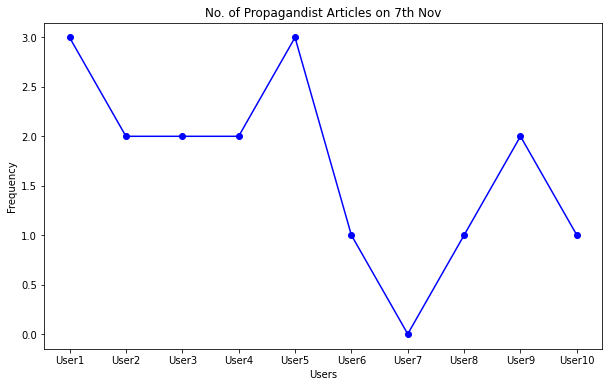

In [3]:
import matplotlib.pyplot as plt

# Data
l7 = [3, 2, 2, 2, 3, 1, 0, 1, 2, 1]

# X-axis labels
users = [f"I{i}" for i in range(1, 11)]

# Plotting line plot for l7
plt.figure(figsize=(10, 6))

plt.plot(users, l7, marker='o', linestyle='-', color='blue', label='User7')

plt.title('No. of Propagandist Articles on 7th Nov')
plt.xlabel('Users')
plt.ylabel('Propaganda Score')

plt.savefig('Nov7.png')
plt.show()


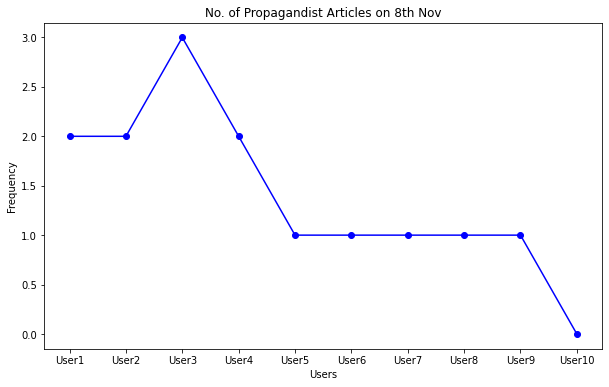

In [209]:
# Plotting line plot for l7
plt.figure(figsize=(10, 6))
plt.plot(users, l8, marker='o', linestyle='-', color='blue', label='User7')

plt.title('No. of Propagandist Articles on 8th Nov')
plt.xlabel('Users')
plt.ylabel('Frequency')

plt.savefig('Nov8.png')
plt.show()


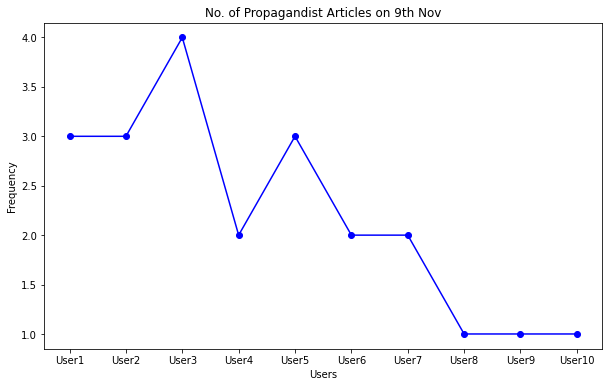

In [208]:
# Plotting line plot for l7
plt.figure(figsize=(10, 6))
plt.plot(users, l9, marker='o', linestyle='-', color='blue', label='User7')

plt.title('No. of Propagandist Articles on 9th Nov')
plt.xlabel('Users')
plt.ylabel('Frequency')

plt.savefig('Nov9.png')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


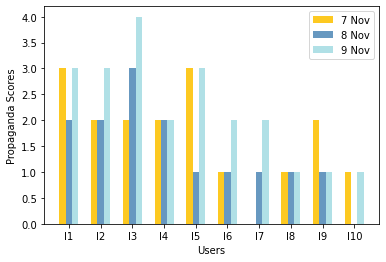

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# User labels
users = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10']

# Data
l7 = [3, 2, 2, 2, 3, 1, 0, 1, 2, 1]
l8 = [2, 2, 3, 2, 1, 1, 1, 1, 1, 0]
l9 = [3, 3, 4, 2, 3, 2, 2, 1, 1, 1]

# X-axis positions
x = np.arange(len(users))

# Bar width
width = 0.2

# Light pastel colors with full opacity
light_pastel_red = '#fdc921'  # Light Red
light_pastel_orange = '#6798c0'  # Moccasin
light_pastel_blue = '#B0E0E6'  # Powder Blue

# Plotting the bar plots with light pastel colors
plt.bar(x - width, l7, width, label='7 Nov', color=light_pastel_red)
plt.bar(x, l8, width, label='8 Nov', color=light_pastel_orange)
plt.bar(x + width, l9, width, label='9 Nov', color=light_pastel_blue)

# Adding labels and title
plt.xlabel('Users')
plt.ylabel('Propaganda Scores')
plt.xticks(x, users)
plt.legend()

plt.savefig('bar_plot_lighter.png', format='png', bbox_inches='tight')
plt.savefig('bar_plot_lighter.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


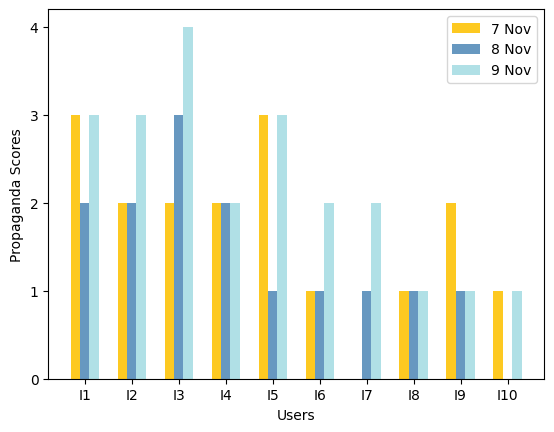

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# User labels
users = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10']

# Data
l7 = [3, 2, 2, 2, 3, 1, 0, 1, 2, 1]
l8 = [2, 2, 3, 2, 1, 1, 1, 1, 1, 0]
l9 = [3, 3, 4, 2, 3, 2, 2, 1, 1, 1]

# X-axis positions
x = np.arange(len(users))

# Bar width
width = 0.2

# Light pastel colors with full opacity
light_pastel_red = '#fdc921'  # Light Red
light_pastel_orange = '#6798c0'  # Moccasin
light_pastel_blue = '#B0E0E6'  # Powder Blue

# Plotting the bar plots with light pastel colors
plt.bar(x - width, l7, width, label='7 Nov', color=light_pastel_red)
plt.bar(x, l8, width, label='8 Nov', color=light_pastel_orange)
plt.bar(x + width, l9, width, label='9 Nov', color=light_pastel_blue)

# Adding labels and title
plt.xlabel('Users')
plt.ylabel('Propaganda Scores')
plt.xticks(x, users)
plt.legend()

# Set y-axis ticks to integers
plt.yticks(np.arange(max(max(l7), max(l8), max(l9)) + 1))

plt.savefig('bar_plot_lighter.png', format='png', bbox_inches='tight')
plt.savefig('bar_plot_lighter.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.show()
